In [2]:
%matplotlib inline
import matplotlib.pylab as plt
import numpy as np
import pymc3 as pm

Bazen, elimizdeki verilerin hepsi aynı olasılık dağılımından gelmez. İki veya daha fazla dağılımdan çekilen veriler bir arada kümelenmiş olur, ve etiketlenmemiş olduğu için ayırmamız mümkün olmaz. Sözgelişi,
* İki ayrı radyoaktif elementten alınan bozunum sayımları
* Farklı segmentlerdeki müşterilerin verileri
* Erkek ve kadın beden ölçümleri

Böyle durumlarda olabilirlik dağılımını tek bir fonksiyon olarak değil, birkaç fonksiyonun ağırlıklı toplamı olarak modellemek daha mantıklıdır. Bu tip modellere _karışım modeli_ denir. Söz gelişi, iki normal dağılımın karışımı olan bir modelde olabilirlik dağılımı şöyle yazılabilir.

$$p(y\ |\ \lambda_1, \lambda_2, \mu_1, \mu_2, \sigma_1, \sigma_2) = 
\lambda_1 \frac{1}{\sqrt{2\pi\sigma_1}} \exp \left[ -\frac{\left(y-\mu_1\right)^2}{2\sigma_1^2}\right]
+ \lambda_2 \frac{1}{\sqrt{2\pi\sigma_2}} \exp \left[ -\frac{\left(y-\mu_2\right)^2}{2\sigma_2^2}\right]$$

Daha genel haliyle, $k$ bileşenli bir karışım modeli şöyle ifade edilebilir.

$$p(y\ | \lambda,\theta) = \lambda_1 f_1(y\ |\ \theta_1) + \lambda_1 f_2(y\ |\ \theta_2) + \cdots + \lambda_1 f_k(y\ |\ \theta_k)$$

## Sentetik veri

İki ayrı normal dağılımdan yüzer adet veri noktası çekerek bir veri kümesi oluşturalım.

In [3]:
μ_1, σ_1 = 4, 0.7
μ_2, σ_2 = 2, 0.4
y1 = np.random.normal(μ_1, σ_1,100)
y2 = np.random.normal(μ_2, σ_2,100)
y = np.concatenate((y1,y2))

Verilerin histogramlarını ve dağılım eğrilerini çizelim.

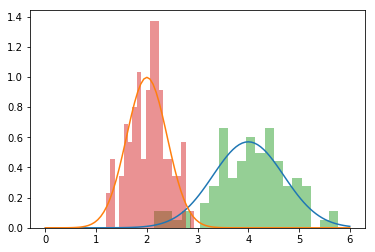

In [4]:
x = np.linspace(0,6,100)
plt.plot(x, np.exp(-(x-μ_1)**2/(2*σ_1**2))/np.sqrt(2*np.pi*σ_1**2))
plt.plot(x, np.exp(-(x-μ_2)**2/(2*σ_2**2))/np.sqrt(2*np.pi*σ_2**2))
plt.hist(y1,bins=20,normed=True, alpha=0.5);
plt.hist(y2,bins=20,normed=True, alpha=0.5);

Karışım modelinde, iki dağılımı her bir grubun nispi oranıyla ağırlıklayarak toplamını alırız.

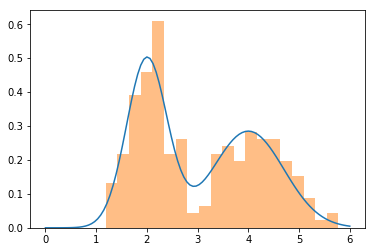

In [5]:
plt.plot(x, 0.5*np.exp(-(x-μ_1)**2/(2*σ_1**2))/np.sqrt(2*np.pi*σ_1**2)+
         0.5*np.exp(-(x-μ_2)**2/(2*σ_2**2))/np.sqrt(2*np.pi*σ_2**2))
plt.hist(y,bins=20, normed=True ,alpha=0.5);

## Model kuruluşu

$$\begin{eqnarray}
w_1, w_2 &\sim& \mathrm{Dir}(1,1)\\
\mu_1 &\sim& N(1,5)\\
\mu_2 &\sim& N(5,5)\\
\sigma_1 &\sim& \mathrm{Unif}(0,1)\\
\sigma_2 &\sim& \mathrm{Unif}(0,1)\\
y &\sim& w_1 N(\mu_1, \sigma_1) + w_2 N(\mu_2, \sigma_2)
\end{eqnarray}$$

In [28]:
karışım_modeli = pm.Model()
with karışım_modeli:
    agirlik = pm.Dirichlet("agirlik", np.array([1,1]))
    ort = pm.Normal("ort", mu=[1,5], sd=5, shape=2)
    stsap = pm.Uniform("stsap", lower=0, upper=1)
    Y = pm.NormalMixture("Y", w=agirlik, mu=ort, sd=stsap,observed=y)
    numuneler = pm.sample(1000)

Auto-assigning NUTS sampler...
Initializing NUTS using advi...
Average ELBO = -568.03: 100%|██████████| 200000/200000 [00:50<00:00, 3996.76it/s]
Finished [100%]: Average ELBO = -568.05
100%|██████████| 1000/1000 [00:06<00:00, 164.60it/s]


## Sonsal sonuçlar

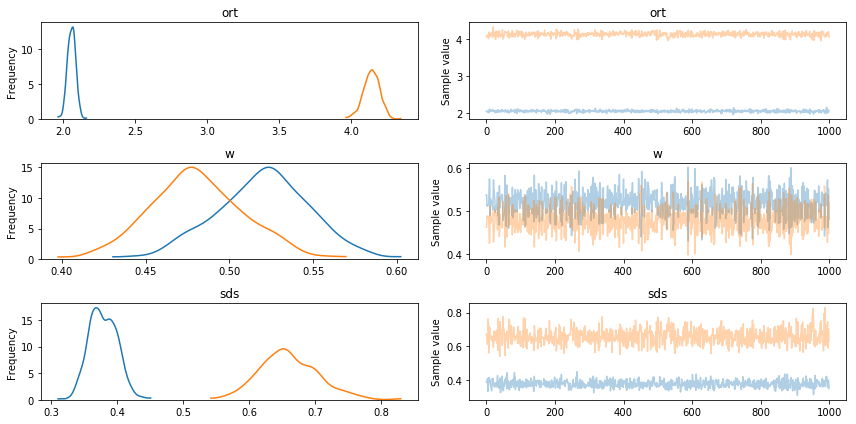

In [29]:
pm.traceplot(numuneler);

In [30]:
pm.summary(numuneler)


ort:

  Mean             SD               MC Error         95% HPD interval
  -------------------------------------------------------------------
  
  2.059            0.028            0.001            [2.007, 2.115]
  4.139            0.056            0.002            [4.028, 4.245]

  Posterior quantiles:
  2.5            25             50             75             97.5
  |--------------|==============|==============|--------------|
  
  2.006          2.039          2.060          2.078          2.115
  4.019          4.103          4.141          4.177          4.242


w:

  Mean             SD               MC Error         95% HPD interval
  -------------------------------------------------------------------
  
  0.520            0.028            0.001            [0.466, 0.576]
  0.480            0.028            0.001            [0.424, 0.534]

  Posterior quantiles:
  2.5            25             50             75             97.5
  |--------------|==============|===========

In [31]:
w1, w2 = np.mean(numuneler.get_values("w"),axis=0)
m1, m2 = np.mean(numuneler.get_values("ort"), axis=0)
sd1, sd2 = np.mean(numuneler.get_values("sds"), axis=0)

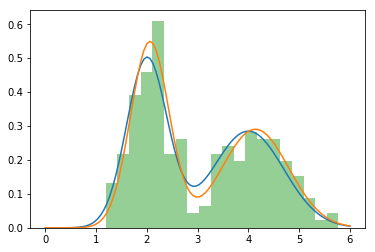

In [32]:
plt.plot(x,
         0.5*np.exp(-(x-μ_1)**2/(2*σ_1**2))/np.sqrt(2*np.pi*σ_1**2)+
         0.5*np.exp(-(x-μ_2)**2/(2*σ_2**2))/np.sqrt(2*np.pi*σ_2**2),
        label="gerçek")
plt.plot(x,
         w1*np.exp(-(x-m1)**2/(2*sd1**2))/np.sqrt(2*np.pi*sd1**2)+
         w2*np.exp(-(x-m2)**2/(2*sd2**2))/np.sqrt(2*np.pi*sd2**2),
        label="sonsal")
plt.hist(y,bins=20, normed=True ,alpha=0.5);

### Çalışma (seçimli)

1. Daha fazla sentetik veri ile analizi tekrarlayın.
1. Yukarıdaki analizi *üç* ayrı normal dağılımdan sentetik veri üreterek tekrarlayın.
1. Yukarıdaki analizi *iki boyutlu* iki normal dağılımla üretilen sentetik veriyle tekrarlayın.

## Çalışma: Erkek ve kadın boy uzunlukları

Ünlü istatistikçi Francis Galton, 1885'de yayınlanan bir araştırmasında 200'den fazla ailede hem ebeveynlerin hem de yetişkin çocukların boylarını ölçtü. Bu araştırmada, teorik _ortalamaya dönüş_ kavramının kuşaklar arasındaki genetik özelliklerde de geçerli olduğunu gösterdi: Uzun ebeveynlerin çocukları kısa, kısa ebeveynlerinki uzun oluyordu.

Burada sadece boy verisiyle ilgileniyoruz. Galton'un orijinal verisinde, cinsiyeti hesaba katmadan, sadece boy uzunluğu verisini alırsak, dağılımı bir karışım olarak modelleyebiliriz. ([Verinin kaynağı](http://www.randomservices.org/random/data/Galton.html))

Önce veri dosyasını `pandas` ile okuyup ilgili veriyi ayıralım.

In [40]:
import pandas as pd
galtondf = pd.read_csv("data/galton.txt","\t")
galtondf.head()

In [45]:
boylar = galtondf["Height"].values

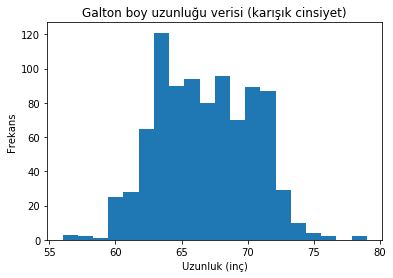

In [67]:
plt.hist(boylar,bins=20)
plt.title("Galton boy uzunluğu verisi (karışık cinsiyet)")
plt.xlabel("Uzunluk (inç)")
plt.ylabel("Frekans");

Yukarıda yaptığımız gibi, bu veriyi iki normal dağılımdan oluşan bir karışım olarak modelleyin. Her bileşenin parametrelerini ve ağırlıklarını belirleyin.

Orijinal veriyi kadınlar ve erkekler olarak ayırın. Histogramlarını, modelden elde edilen parametreler ile çizdirdiğiniz sonsal dağılım eğrileriyle beraber çizdirin. Yeterince iyi bir sonuç var mı?

### Çözüm

In [55]:
boy_modeli = pm.Model()
with boy_modeli:
    boy_agirlik = pm.Dirichlet("boy_agirlik", np.array([1,1]))
    boy_ort = pm.Normal("boy_ort", mu=[60, 70], sd=20, shape=2)
    boy_stsap = pm.Uniform("boy_stsap", lower=0, upper=30, shape=2)
    B = pm.NormalMixture("B", w=boy_agirlik, mu=boy_ort, sd=boy_stsap, observed=boylar)
    boy_numuneler = pm.sample(1000)

Auto-assigning NUTS sampler...
INFO:pymc3:Auto-assigning NUTS sampler...
Initializing NUTS using advi...
INFO:pymc3:Initializing NUTS using advi...
Average ELBO = -4,839.9: 100%|██████████| 200000/200000 [01:22<00:00, 2419.24it/s]
Finished [100%]: Average ELBO = -4,839.9
INFO:pymc3:Finished [100%]: Average ELBO = -4,839.9
100%|██████████| 1000/1000 [00:37<00:00, 77.45it/s]


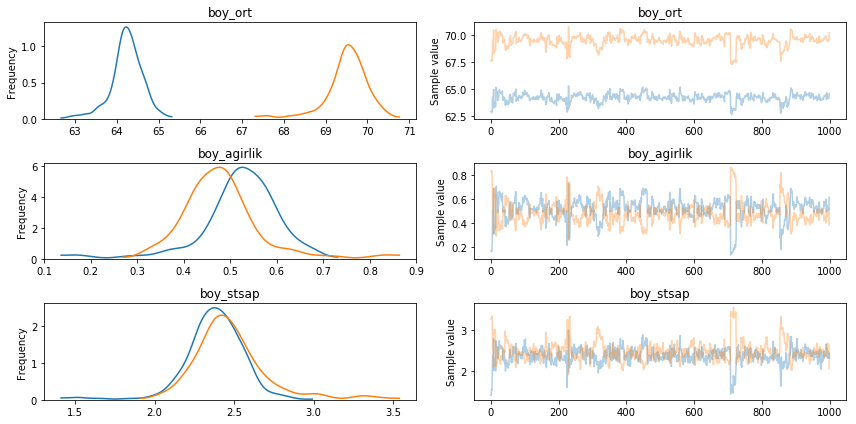

In [57]:
pm.traceplot(boy_numuneler);

In [64]:
pm.summary(boy_numuneler)


boy_ort:

  Mean             SD               MC Error         95% HPD interval
  -------------------------------------------------------------------
  
  64.232           0.385            0.027            [63.474, 65.067]
  69.502           0.524            0.040            [68.410, 70.493]

  Posterior quantiles:
  2.5            25             50             75             97.5
  |--------------|==============|==============|--------------|
  
  63.249         64.061         64.246         64.464         64.962
  68.053         69.310         69.550         69.812         70.336


boy_agirlik:

  Mean             SD               MC Error         95% HPD interval
  -------------------------------------------------------------------
  
  0.518            0.089            0.007            [0.347, 0.689]
  0.482            0.089            0.007            [0.311, 0.653]

  Posterior quantiles:
  2.5            25             50             75             97.5
  |--------------|======

In [60]:
w1, w2 = np.mean(boy_numuneler.get_values("boy_agirlik"),axis=0)
m1, m2 = np.mean(boy_numuneler.get_values("boy_ort"), axis=0)
sd1, sd2 = np.mean(boy_numuneler.get_values("boy_stsap"), axis=0)

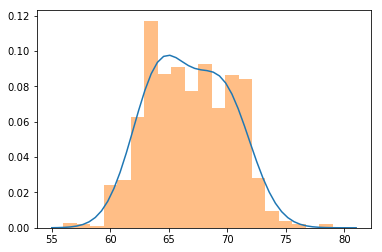

In [63]:
b = np.linspace(55,81,50)
plt.plot(b,
         w1*np.exp(-(b-m1)**2/(2*sd1**2))/np.sqrt(2*np.pi*sd1**2)+
         w2*np.exp(-(b-m2)**2/(2*sd2**2))/np.sqrt(2*np.pi*sd2**2),
        label="sonsal")
plt.hist(boylar,bins=20, normed=True ,alpha=0.5);

In [ ]:
m1, m2 = np.mean(trace["ort"],axis=0)
sd1, sd2 = np.mean(trace["sds"], axis=0)